In this notebook I run a deep learning models then compare the results to dummy models and looks closely at false positives and predictions.

In [2]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import re, os, collections, itertools, uuid, logging
import tempfile

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely


%matplotlib inline
# %precision 4
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6) # bigger plots
sns.set_palette("Set2", 10)

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# os.environ['CUDA_VISIBLE_DEVICES']="" # to disable gpu, so I can do large predictions in memory

In [ ]:
import keras
import tensorflow
import sklearn
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape, InputLayer, Permute, RepeatVector, Dropout, LocallyConnected1D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D
from keras.layers.convolutional import Convolution1D, MaxPooling1D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.layers import (Input, LocallyConnected1D, ZeroPadding1D, Cropping1D, Embedding, Merge, merge,
    Cropping2D, Convolution1D, Convolution2D, Deconvolution2D, BatchNormalization, UpSampling1D, RepeatVector)
from keras.layers import embeddings, convolutional, activations, normalization, advanced_activations, ZeroPadding2D, UpSampling2D
from keras.models import Model
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

Using TensorFlow backend.


In [ ]:
helper_dir = str(Path('.').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s2, download_image, bands_s1, bands_l7, bands_l8
from leak_helpers.geometry import diffxy, resample_polygon
from leak_helpers.modelling import ImageDataGenerator, dice_coef_loss
from leak_helpers.visualization import imshow_bands
from leak_helpers.analysis import  calculate_result_class, find_best_dummy_classification, parse_classification_report
from leak_helpers.modelling.filters import is_not_cloudy, is_not_center_cloudy, is_image_within, is_leak, filter_split_data, normalise_bands

In [ ]:
keras.__version__, tensorflow.__version__

In [195]:
# params
data_path = Path('../data/scraped_satellite_images/l7-AUTX_v2_LANDSAT-LE7_L1T'),
#  Path('../data/scraped_satellite_images/l8-AUTX_v2_LANDSAT-LC8_L1T'), # good
#  Path('../data/scraped_satellite_images/NAIP_all_v2-USDA-NAIP-DOQQ'), # filter to 0
#  Path('../data/scraped_satellite_images/s1-all_COPERNICUS-S1_GRD'),
#  Path('../data/scraped_satellite_images/s2-AUTX_v6_COPERNICUS-S2'),

data_path = Path('../data/scraped_satellite_images/s1-all_COPERNICUS-S1_GRD'),

notebook_name = 'leak_detection_CNN'
batch_size=128*2 # ideally it's 300-600 so the mean is similar to the global mean, but gpu mem is limited
random_seed = 1337
test_fraction = 0.3
timespan_before = 60*60*24*1.134 # we will only take image that where X seconds before the leak (e.g. 1 day)
max_cloud_cover = 0.10 # cloud cover must less than this
thresh = 0.5 # balance precision vs recall
balanced_classes = True
normalized = False
filter_center_cloudy = False

# I ran hyperoptimisation to find the best filters
image_data_gen_params=dict(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
        channel_shift_range=0.08,
        rotation_range=10,
        width_shift_range=0.08,
        height_shift_range=0.08,
        horizontal_flip=True,
        vertical_flip=True,
       dim_ordering='th',
        rescale=0.30,
    #     zoom_range=0.05,
    #     shear_range=0.05,
)

# derived
ts=arrow.utcnow().format('YYYYMMDD-HH-mm-ss')
model_name = '{notebook_name:}__{ts:}'.format(ts=ts,notebook_name=notebook_name)
outdir = Path('../output').joinpath(model_name)
outdir.makedirs_p()
outdir

Path('../output/leak_detection_CNN__20170326-09-19-54')

In [196]:
script_metadata = json.load(open(data_path.joinpath('script_metadata.json')))
# test load
import h5py
metadatas = json.load(open(data_path.joinpath('data_metadata.json')))
with h5py.File(data_path.joinpath('data.h5'),'r') as h5f:
    X_raw = h5f['X'][:]
    y_raw = h5f['y'][:]
X_raw.shape, y_raw, metadatas[0].keys(), data_path

AttributeError: 'tuple' object has no attribute 'joinpath'

## filter data

In [ ]:
X_train, y_train, metadata_train, X_val, y_val, metadata_val, X_test, y_test, metadata_test = filter_split_data(
    X_raw,
    y_raw,
    metadatas,
    max_cloud_cover=max_cloud_cover, 
    timespan_before=timespan_before,
    test_fraction=test_fraction, 
    random_seed=random_seed,
    balanced_classes=balanced_classes,
    normalized=normalized,
    filter_center_cloudy=False
)  
print((len(X_train)+len(X_test)+len(X_val))/len(X_raw))
print(X_train.shape,y_train.shape, len(metadata_train))
print(X_test.shape,y_test.shape, len(metadata_test))
print(X_val.shape,y_val.shape, len(metadata_val))
print(y_train.mean(),y_test.mean(),y_val.mean())

## augument data



In [ ]:


datagen = ImageDataGenerator(
**image_data_gen_params
)

datagen.fit(X_train)

datagen

# Try a quick randomforest

In [ ]:
# what about a sklearn model?
X_train2b = X_train.reshape((len(X_train),-1))
X_val2b = X_val.reshape((len(X_val),-1))
X_test2 = X_test.reshape((len(X_test),-1))
    
import sklearn.tree
import sklearn.ensemble
# model = sklearn.tree.DecisionTreeRegressor(max_depth=150)
model = sklearn.ensemble.RandomForestRegressor(n_estimators=150,max_depth=150,n_jobs=3)
# model = sklearn.ensemble.RandomForestClassifier(n_estimators=150,max_depth=150,n_jobs=3)
model.fit(X_train2b, y_train) 
y_pred = model.predict(X_val2b)
score = model.score(X_val2b, y_val)
thresh=0.9
report = parse_classification_report(sklearn.metrics.classification_report(y_val>thresh,y_pred>thresh,target_names=target_names))
matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_val>thresh, y_pred>thresh)
print('score', score)
print('matthews_corrcoef', matthews_corrcoef)
report

# model

- batch norm helped
- normalising X helped
- unet didn't
- unbalanced didn't much
- pretraining with VGG just shortened training time

Refs:
- conv only net uses strides instead of MaxPooling
- example of heatmap generationg https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/convnets.py

In [ ]:
# # try reusing VGGnet model... to many params, 
# # plus I have to reduce to 3 channels which means I probobly make a bottleneck
# from keras import applications
# xception = keras.applications.VGG16(include_top=False, input_shape=(X.shape[2]*2, X.shape[3]*2, 3))
# for _ in range(8):
#     xception.layers.pop()
# xception.summary()
# xception=Model(xception.get_input_at(0), xception.layers[-1].output)


# model = Sequential()
# input_shape = (X.shape[1], X.shape[2], X.shape[3])
# model.add(InputLayer(input_shape=input_shape, name='input'))
# model.add(Permute((2,3,1)))
# model.add(Convolution2D(3, 1, 1, activation='relu', name='conv1_1'))
# model.add(UpSampling2D((2,2)))
# model.add(xception)

# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(128, 3, 3, activation='relu', name='conv4_1'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(128, 3, 3, activation='relu', name='conv4_2'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(128, 3, 3, activation='relu', name='conv4_3'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))
# model.add(MaxPooling2D((2,2)))
    
# model.add(Convolution2D(1,1,1,border_mode='same'))
# model.add(Flatten())
# model.add(Activation('sigmoid'))
# # model.compile(loss=dice_coef_loss,optimizer='nadam', metrics=['accuracy','matthews_correlation'])
# model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy','matthews_correlation'])

# model.summary()

In [ ]:
# # conv model, with normal max pooling, doesn't seem to help accuray or heatmap

# def get_model(input_shape, batch_norm=True, activation='relu', border_mode='same'):

#     pooling = 2
#     model = Sequential()
#     # batch_input_shape=(None, X_train.shape[1], pixel_length, pixel_length)
#     model.add(InputLayer(input_shape=input_shape, name='input'))
#     model.add(Permute((2,3,1)))

# #     model.add(Convolution2D(32,3,3,border_mode=border_mode))
# #     if batch_norm: model.add(BatchNormalization())
# #     model.add(Activation(activation))

# #     model.add(ZeroPadding2D((1,1)))
# #     model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
#     model.add(MaxPooling2D((2,2)))

# #     model.add(ZeroPadding2D((1,1)))
# #     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
#     model.add(MaxPooling2D((3,3)))

# #     model.add(ZeroPadding2D((1,1)))
# #     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3_1'))
# #     model.add(ZeroPadding2D((1,1)))
# #     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3_2'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3_3'))
#     model.add(MaxPooling2D((2,2)))

# #     model.add(ZeroPadding2D((1,1)))
# #     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv4_1'))
# #     model.add(ZeroPadding2D((1,1)))
# #     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv4_2'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(128, 3, 3, activation='relu', name='conv4_3'))
#     model.add(MaxPooling2D((2,2)))
    
#     model.add(Convolution2D(1,1,1,border_mode=border_mode))

#     model.add(Flatten())
#     model.add(Activation('sigmoid'))
    
#     model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy'])
    
#     return model

# input_shape = (X.shape[1], X.shape[2], X.shape[3])
# model = get_model(input_shape, border_mode='same' ,batch_norm=True)
# model.compile(loss=dice_coef_loss,optimizer='nadam', metrics=['accuracy','matthews_correlation'])
# model.summary( )


In [198]:
# conv model
from keras.regularizers import l2, l1, activity_l2, activity_l1, activity_l1l2, l1l2

def get_model(input_shape, batch_norm=True, activation='relu', border_mode='same', channels = 14*5, l1=0, l2=0):
    
    def activation_f(activation=activation):
        if isinstance(activation, str):
            return activation
        else:
            return activation()
    def reg(l1,l2):
        return dict(
            W_regularizer=l1l2(l1,l2),
            b_regularizer=l1l2(l1,l2),
#             activity_regularizer=activity_l1l2(l1,l2)
        )
    model = Sequential()
    # batch_input_shape=(None, X_train.shape[1], pixel_length, pixel_length)
    model.add(InputLayer(input_shape=input_shape, name='input'))
    model.add(Permute((2,3,1)))
    
    model.add(Convolution2D(channels,1,1,border_mode=border_mode,**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))

    pooling = 5
    model.add(Convolution2D(channels,pooling,pooling,border_mode=border_mode,subsample=(pooling, pooling),**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))
    
    model.add(Convolution2D(channels,1,1,border_mode=border_mode,**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))
    
    pooling = 5
    model.add(Convolution2D(channels*2,pooling,pooling,border_mode=border_mode,subsample=(pooling, pooling),**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))
    
    model.add(Convolution2D(channels,1,1,border_mode=border_mode,**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))

#     model.add(Convolution2D(channels*3,3,3,border_mode=border_mode,subsample=(3, 3)))
#     if batch_norm: model.add(BatchNormalization())
#     model.add(Activation(activation))

#     pooling = 3
#     model.add(Convolution2D(channels*pooling,pooling,pooling,border_mode=border_mode,subsample=(pooling, pooling)))
#     if batch_norm: model.add(BatchNormalization())
#     model.add(Activation(activation))

#     pooling = 3
#     model.add(Convolution2D(channels*pooling,pooling,pooling,border_mode=border_mode,subsample=(pooling, pooling)))
#     if batch_norm: model.add(BatchNormalization())
#     model.add(Activation(activation))

#     model.add(Convolution2D(channels*2*3*2,2,2,border_mode=border_mode,subsample=(2, 2)))
#     if batch_norm: model.add(BatchNormalization())
#     model.add(Activation(activation))
    
    model.add(Convolution2D(1,1,1,border_mode=border_mode,**reg(l1,l2)))
    model.add(Flatten())
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy'])
    
    return model



In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = get_model(input_shape, 
                  border_mode='same', 
                  activation=keras.layers.advanced_activations.LeakyReLU, 
                  batch_norm=True, 
                  channels=9*3, 
                  l1=0.01/5, 
                  l2=0.01/5
                 )
if balanced_classes:
    model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy','matthews_correlation'])
else:
    model.compile(loss=dice_coef_loss,optimizer='nadam', metrics=['accuracy','matthews_correlation'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 9, 25, 25)     0                                            
____________________________________________________________________________________________________
permute_22 (Permute)             (None, 25, 25, 9)     0           input[0][0]                      
____________________________________________________________________________________________________
convolution2d_127 (Convolution2D (None, 25, 25, 27)    270         permute_22[0][0]                 
____________________________________________________________________________________________________
batchnormalization_91 (BatchNorm (None, 25, 25, 27)    108         convolution2d_127[0][0]          
___________________________________________________________________________________________

In [ ]:


# pretrain/test
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    samples_per_epoch=len(X_train)*4,
    verbose=0, 
    nb_epoch=60, 
    validation_data=[X_val2,y_val2],
    callbacks=[
                        TQDMNotebookCallback(),
                        keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
                        keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
                        keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1),
#                         keras.callbacks.ModelCheckpoint('/tmp/model.hdf5', save_best_only=True, monitor='val_matthews_correlation'),
    #                     keras.callbacks.CSVLogger(output_dir.joinpath('log-%s.log'%ts)),
    #                     keras.callbacks.TensorBoard(log_dir=output_dir),
    ]
)
pd.DataFrame(history.history).plot()

Notes for joined l7 filtered @2day. 

- how much can I overfit? to matthews_c of ~0.33 after 30 epochs. (jitter of 1% no reg, added 1x1 convolutions)
- how much can I overfit? to matthews_c of ~0.22 after 30 epochs. (jitter of 4% no reg, added 1x1 convolutions)
- how much can I overfit? to matthews_c of ~0.23 after 30 epochs. (rot 10deg    no reg, added 1x1 convolutions)
- how much can I overfit? to matthews_c of ~0.17 after 30 . (rot 20deg, jit 6% no reg, added 1x1) 0.012 val_mc
- how much can I overfit? to matthews_c of ~0.09 after 30 . (rot 20deg, jit 10% no reg, added 1x1) 0.05 val_mc
- mc ~ 0.24 for 0.01/100 reg (no jitter or rot), 0 val_mc
- mc = 0.16 for 0.01/100 reg, 4% jitter, 10deg rot => 0 val_mc
- how much can I overfit? to matthews_c of 0.12 ? after 30 . (rot 45deg, jit 6% no reg, added 1x1) 0? 0.05 val_mc


Same for 1 days? mc=0.18, val_mc=0
- mc = 0.16 for 0.01/100 reg, 6% jitter, 45deg rot => 0.016 val_mc
- mc = 0.04 for 0.01/10 reg, 6% jitter, 45deg rot => 0.0 val_mc

- how high can I get val_mc?
    - with jitter
    - with reg

# Metrics

Our main metrics are f-score and matthews correlation (when using unbalanced data). We can compare them to dummy scores as a baseline.


In [204]:
y_pred = model.predict(X_test).T[0]
y_true = y_test
target_names = ['no leak','leak']
np.array([y_pred.T,y_true]).T[:10]

array([[ 0.00503693,  1.        ],
       [ 0.63794225,  1.        ],
       [ 0.40719885,  1.        ],
       [ 0.77593845,  1.        ],
       [ 0.83190638,  0.        ],
       [ 0.93578202,  0.        ],
       [ 0.94780976,  1.        ],
       [ 0.98024231,  1.        ],
       [ 0.03768677,  0.        ],
       [ 0.99557245,  0.        ]], dtype=float32)

In [205]:
# Val and test joined since we don't hae many samples
X_use, y_use = X_val2, y_val2
y_pred = model.predict(X_use).T[0]
print(sklearn.metrics.classification_report(y_use>thresh,y_pred>thresh,target_names=target_names))
matthews_corrcoef=sklearn.metrics.matthews_corrcoef(y_use > thresh, y_pred > thresh)
print('matthews_corrcoef:',matthews_corrcoef)

             precision    recall  f1-score   support

    no leak       0.54      0.25      0.34       435
       leak       0.51      0.79      0.62       430

avg / total       0.52      0.52      0.48       865

matthews_corrcoef: 0.0408788588367


In [207]:
# X_test
X_use, y_use = X_test, y_test
y_pred = model.predict(X_use).T[0]
print(sklearn.metrics.classification_report(y_use>thresh,y_pred>thresh,target_names=target_names))
matthews_corrcoef=sklearn.metrics.matthews_corrcoef(y_use > thresh, y_pred > thresh)
print('matthews_corrcoef:',matthews_corrcoef)

             precision    recall  f1-score   support

    no leak       0.52      0.24      0.33       249
       leak       0.52      0.79      0.63       260

avg / total       0.52      0.52      0.48       509

matthews_corrcoef: 0.0351731773129


In [208]:
# X_val
X_use, y_use = X_val, y_val
y_pred = model.predict(X_use).T[0]
print(sklearn.metrics.classification_report(y_use>thresh,y_pred>thresh,target_names=target_names))
matthews_corrcoef=sklearn.metrics.matthews_corrcoef(y_use > thresh, y_pred > thresh)
print('matthews_corrcoef:',matthews_corrcoef)

             precision    recall  f1-score   support

    no leak       0.57      0.25      0.35       186
       leak       0.49      0.79      0.60       170

avg / total       0.53      0.51      0.47       356

matthews_corrcoef: 0.0483429305512


In [46]:
# accuracy X_val
model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy','mean_squared_error','precision','recall','fbeta_score','fmeasure','matthews_correlation'])
score = model.evaluate(X_val,y_val, batch_size=batch_size)
dict(zip(model.metrics_names,score))

256/446 [================>.............] - ETA: 0s

{'acc': 0.50896863178287388,
 'fbeta_score': 0.15441985996314764,
 'fmeasure': 0.15441985996314764,
 'loss': 0.86807007185546803,
 'matthews_correlation': 0.087609365448823417,
 'mean_squared_error': 0.25053535408503269,
 'precision': 0.68639762706286167,
 'recall': 0.087276622786650215}

In [47]:
# accuracy X_test
model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy','mean_squared_error','precision','recall','fbeta_score','fmeasure','matthews_correlation'])
score = model.evaluate(X_test,y_test, batch_size=batch_size)
score_test = dict(zip(model.metrics_names,score))
score_test

638/638 [==============================] - 0s     


{'acc': 0.51253919635073142,
 'fbeta_score': 0.14246446683675892,
 'fmeasure': 0.14246446683675892,
 'loss': 0.86614869847940423,
 'matthews_correlation': 0.04569225805610138,
 'mean_squared_error': 0.2495790272484005,
 'precision': 0.58896581954716887,
 'recall': 0.082821401168933856}

In [48]:
weights_file  = outdir.joinpath('weights.h5')
weights_file.dirname().makedirs_p()
model.save_weights(weights_file)
print(weights_file)

model_file = outdir.joinpath('model.h5')
model_file.dirname().makedirs_p()
model.save(model_file)
print(model_file)

# score_file = outdir.joinpath('score.json')
# score_file.dirname().makedirs_p()
# with open(score_file,'w') as fo:
#     fo.write(report_test)
#     fo.write(json.dumps(score_test,indent=4))

../output/leak_detection_CNN__20170324-08-00-24/weights.h5


OSError: Unable to create file (Unable to truncate a file which is already open)

# null model test

this gives the base case. The trivial level of accuracy

In [116]:
df,best = find_best_dummy_classification(X_raw,y_raw, n=15)
df[:5]

/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,matthews_corrcoef,report,score,strategy
67,0.031038,precision recall f1-score supp...,0.494960,classifier_uniform
27,0.020970,precision recall f1-score supp...,0.496976,classifier_stratified
73,0.020145,precision recall f1-score supp...,0.484879,classifier_uniform
81,0.020064,precision recall f1-score supp...,0.486139,classifier_stratified
33,0.017382,precision recall f1-score supp...,0.493700,classifier_stratified


# view

##  View on map: fp, fn, tp, tn

Lets view the false positives on the map to see what can cause them

- false negatives: look like we miss some in the town when the pipe is obscured, but it's ok on lawn, parks, streetsides
- false positive: near water e.g. river, pool (or repairs that say "tmp" so maybe I should not include these)

In [63]:
y_pred = model.predict(X_test).T[0]
y_true = y_test
mds = metadata_test

# make a dataframe of results
geojson = [d['leak']['features'][0] for d in mds]
gdf = gpd.GeoDataFrame.from_features(geojson, crs= {'init': 'epsg:4326', 'no_defs': True})



# addd stats
gdf['y_pred']=y_pred
gdf['y_true']=y_true
gdf['confidence']=np.abs(y_pred-0.5)*2
gdf['result_class']=calculate_result_class(y_pred, y_true, words=True)

# calculate time in days
tss = []
for md in mds:
    t_image = arrow.get(md['image']['properties']['system:time_end']/1000)
    t_leak = arrow.get(md['leak']['features'][0]['properties']['REPO_Date'])
    td=t_image-t_leak
    tss.append(td.total_seconds()/(60*60*24))
gdf['image_time_days'] = tss
gdf['image_date'] = [arrow.get(md['image']['properties']['system:time_end']/1000).format() for md in mds]


color_dict = {
        'fn':'orange', # fn
        'fp':'red', # fp
        'tn':'blue', # tn
        'tp':'green' # tp
        }
def rgb_to_hex(red, green, blue, alpha=1.0):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red*alpha, green*alpha, blue*alpha)

def color(x):
    """calc color for a row based on result class and confidence"""
    color_dict = {
            'fn': [197, 66, 244], # fn
            'fp': [244, 66, 66], # fp
            'tn': [66, 78, 244], # tn
            'tp': [66, 244, 75] # tp
            }
    rgba=color_dict[x['result_class']]+[x['confidence']]
    return rgb_to_hex(*rgba)

gdf['marker-color']=gdf.apply(color,axis=1)

/home/isisilon/.virtualenvs/py3syspck/lib/python3.4/site-packages/ipykernel/__main__.py:36: DeprecationWarning: automatic int conversions have been deprecated


In [64]:
location = np.array(gdf.sample().geometry.values[0].xy).T[0][::-1].tolist()

In [65]:
# export for geojson.io
# gdf['marker-symbol']='triangle'
geojson_json = gdf.to_json()
open(outdir.joinpath('results.geojson'),'w').write(geojson_json)

220654

In [66]:
# view on maps
import folium
# from https://jsfiddle.net/marracci/z6hpu087/
dg_recent='http://api.tiles.mapbox.com/v4/digitalglobe.nal0g75k/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiZGlnaXRhbGdsb2JlIiwiYSI6ImNpcGg5dHkzYTAxM290bG1kemJraHU5bmoifQ.CHhq1DFgZPSQQC-DYWpzaQ'


samples = gdf.sample(min(len(gdf),100))

# example https://github.com/python-visualization/folium/blob/master/examples/Geopandas.ipynb
map_osm = folium.Map(tiles=dg_recent, location=location, attr= "DigitalGlobe, Inc", control_scale=True, zoom_start=15, max_zoom=22, min_zoom=0.1)

# TODO add these
results_feature_g=dict()
for g in ['fp','fn','tn','tp']:
        results_feature_g[g] = FeatureGroup(name=g)

for i in tqdm(range(len(samples))):
    
    x = samples.iloc[i]
    # choose properties to show on the map popup
    xx=x[[
        'leak_id','REPO_Date','y_pred','y_true','confidence','result_class','image_time_days'
    ]]
    fgroup = results_feature_g[xx['result_class'].values[0]]
    folium.Marker(
        np.array(x.geometry.xy).T[0][::-1],
              popup=folium.Popup(folium.element.IFrame(xx.to_frame().to_html(), width=500, height=300), max_width=2650),
#               icon=folium.Icon(color=color_dict[x['result_class']])
            icon=folium.Icon(icon_color=x['marker-color'])
             ).add_to(fgroup)
results_html = outdir.joinpath('results.html')

for g in ['fp','fn','tn','tp']:
        results_feature_g[g].add_to(map_osm)
folium.LayerControl().add_to(map_osm)

map_osm.save(results_html)
results_html

Path('../output/leak_detection_CNN__20170321-03-20-31/results.html')

In [67]:
from IPython.core.display import display, HTML
link=results_html.abspath()
print('open in a new window by copying:')
display(HTML('<a href="file://{link:}" target="_blank" >file://{link:}</a>'.format(link=link)))

open in a new window by copying:


## Make a prediction

Here we download a recent satellite image and then make predictions where pipes cross.

In [419]:
# init
crs_grid = 3857
# if the satelite's note included in the metadata jsut add it
satellite = script_metadata['satellite']
resolution_min=script_metadata['resolution_min'] #10
distance=3000
pixel_length=int(distance/resolution_min)

point = shapely.geometry.Point(116.7413748,-31.8739154) # york, WA, AY


temp_dir = cache_dir = Path(tempfile.mkdtemp())

#### Download recent sat image

In [ ]:
# find latest image
import ee
ee.Initialize() # should give no errors, if so follow instructions

# get boundary to crop/search image with
coords = np.array(point.xy)[:, 0].tolist()
geom = ee.Geometry.Point(coords)
bound = ee.Geometry.buffer(geometry=geom, distance=distance)
boundary = bound.bounds()

# search for image
sentinel2_before = ee.ImageCollection(satellite)\
    .filterBounds(boundary)\
    .sort('system:time_start', opt_ascending=False) # first will be latest
assert sentinel2_before.size().getInfo()>0,'oh no, no image results'
image = ee.Image(sentinel2_before.first()).clip(boundary)
info = image.getInfo()
image

In [1]:


path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
    name=arrow.now().format('YYYYMMDD-HH-mm-ss'),
    report=True
)
path

NameError: name 'temp_dir' is not defined

(15.0, 0.0, 12881182.5, 0.0, -15.0, -3723997.5)

In [77]:
# download and norm the image
bands = script_metadata['bands']
data = tifs2np(path,files,bands=bands)
print([d.shape for d in data])

[(786, 781), (786, 781), (786, 781), (786, 781), (786, 781), (786, 781), (786, 781), (786, 781), (786, 781), (786, 781), (786, 781), (786, 781)]


(12, 786, 781)

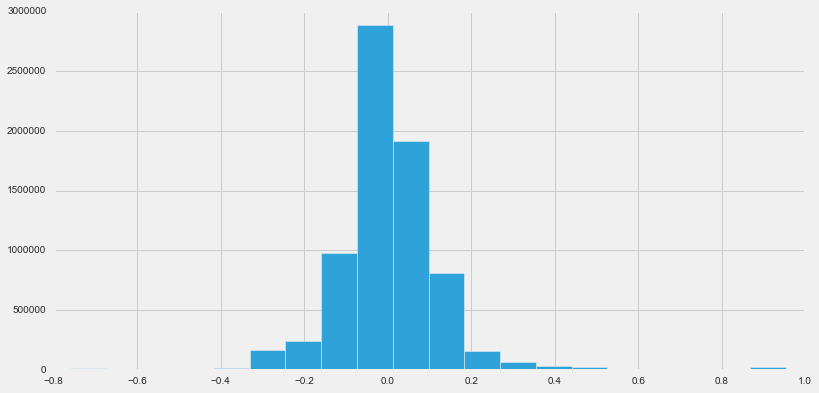

In [78]:


# # now if the size is wrong let's interp it
# for i in range(len(data)):
#     if (data[i].shape[0]!=pixel_length*2) or (data[i].shape[1]!=pixel_length*2):
#         data[i]=sp.misc.imresize(data[i],size=(pixel_length*2,pixel_length*2),interp='cubic', mode='F')
# data=np.array([d.tolist() for d in data], dtype=np.float32)

# interpolate
# data=np.array([sp.misc.imresize(x,size=(pixel_length*2,pixel_length*2),interp='cubic', mode='F') for x in data])

# normalization
if normalization:  
    data=normalise_bands(np.expand_dims(data,0))[0]

pd.Series(data.flatten()).hist(bins=20)
data.shape

In [457]:
image_time = arrow.get(info['properties']['system:time_end']/1000)
print('image time:',image_time)

image time: 2017-03-14T02:11:22.865999+00:00


In [ ]:
# check the weather TODO https://openweathermap.org/history#name
import requests
q='http://history.openweathermap.org/data/2.5/history/city?lat={lat:}&lon={lon:}&type=hour&start={start:}&end={end:}'.format(
    lat=,
    lon=,
    start=,
    end=,    
)
d=request.get(q).json()
d['list'][0]['weather'][0]

In [1]:
# view sat image for QC

image_time = arrow.get(info['properties']['system:time_end']/1000)
print('image taken at', image_time.to('Australia/Perth').format())

im2=data[1:4,:,:].copy()
im3 = np.transpose(im2,(1,2,0))[:,:,::-1]
im3+=0.5 # move it to 0-1
plt.figure(figsize=(15,15))
plt.imshow(im3, interpolation='none')

NameError: name 'arrow' is not defined

#### Filter pipes

In [81]:
%%time
# load pipe locations, slow
pipes_df = gpd.GeoDataFrame.from_file('../data/watercorp_pipe_network/pipes.zip', vfs='zip')
pipes_df=pipes_df.to_crs(epsg=crs_grid)

CPU times: user 52.7 s, sys: 244 ms, total: 52.9 s
Wall time: 52.5 s


In [82]:
# filter pipes to ones inside the image
import shapely
box = shapely.geometry.box(
    minx=x0,
    miny=y0,
    maxx=x0+rx*data.shape[1],
    maxy=y0+ry*data.shape[2],
)
j=pipes_df.geometry.apply(lambda x:box.intersects(x))
pipes_intersecting = pipes_df[j]
pipes_intersecting
print('{:2.2%}'.format(len(pipes_intersecting)/len(pipes_df)))

4.25%


In [83]:
pipes_df=None # to big for memory


points 75439


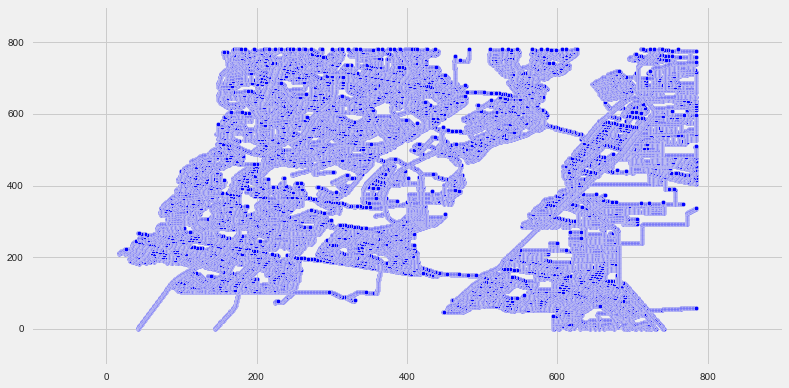

In [443]:
# interpolate pipes to the image
# for each pipe resample, then snap to  pixel coords, keep the unique coordinated in bouunds
ppcs=[]
for i in tqdm(range(len(pipes_intersecting))):
    pipe = pipes_intersecting.geometry.iloc[i]
    points=np.array(pipe.xy).T

    # resample along length, this function is 100x faster than shapley `line.interpolate(distance)`
    points_resampled=resample_polygon(points, n=rx/10)
    if type(points_resampled)==tuple:
        points_resampled=points_resampled[0]
#         print(len(points))

    # convert to pixel coords
    points_pc=(points_resampled-np.array([x0,y0]))/np.array([rx,ry])
#         print(len(pp))

    # then round
    points_pc=np.around(points_pc)

    ppcs.append(points_pc)

ppcs=np.concatenate(ppcs)

# also remove out of bounds ones
in_bounds = (ppcs[:,0]>0) * (ppcs[:,0]<data.shape[1]) * (ppcs[:,1]>0) * (ppcs[:,1]<data.shape[2])
ppcs=ppcs[in_bounds]

# remove dups
def unique_rows(a):
    order = np.lexsort(a.T)
    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1) 
    return a[ui]
ppcs=unique_rows(ppcs)


ppcs = ppcs.astype(int)
print('points',len(ppcs))

plt.scatter(ppcs[:,0],ppcs[:,1])
ppcs_raw = ppcs
# ppcs

In [425]:
# if its too big reduce it here
# ppcs = ppcs_raw[::2] # reduce by 2
# ppcs = ppcs_raw[:100] # crop to 100
ppcs = ppcs_raw

### Format data and predict

In [426]:
# get the image around each point and stack into a matrix/array

# now we want to get the image around each point
w2=int(X_train.shape[2]/2)
h2=int(X_train.shape[3]/2)
wd=data.shape[1]
hd=data.shape[2]

# TODO filter ppp so they don't go over the edge?
# or just pad
padding=max(h2*2,w2*2)
data2=np.pad(data,padding,mode='constant')[padding:-padding] # pad it but not the channels
X2 = []

# pp=pp[:50] # test crop
for ppp in ppcs:
    i0,i1,j0,j1=[ppp[0]-w2,ppp[0]+w2+1, ppp[1]-h2,ppp[1]+h2+1]
    i0=np.clip(i0,0-padding,wd+padding*2)
    i1=np.clip(i1,0-padding,wd+padding*2)
    j0=np.clip(j0,0-padding,hd+padding*2)
    j1=np.clip(j1,0-padding,hd+padding*2)
    x=data2[:,i0+padding:i1+padding,j0+padding:j1+padding]
    X2.append(x)

X2 = np.array(X2)
X2.shape

(75439, 12, 25, 25)

74752/75439 [============================>.] - ETA: 0s

count    75439.000000
mean         0.443283
std          0.037193
min          0.184917
25%          0.428097
50%          0.439268
75%          0.462388
max          0.641456
dtype: float64

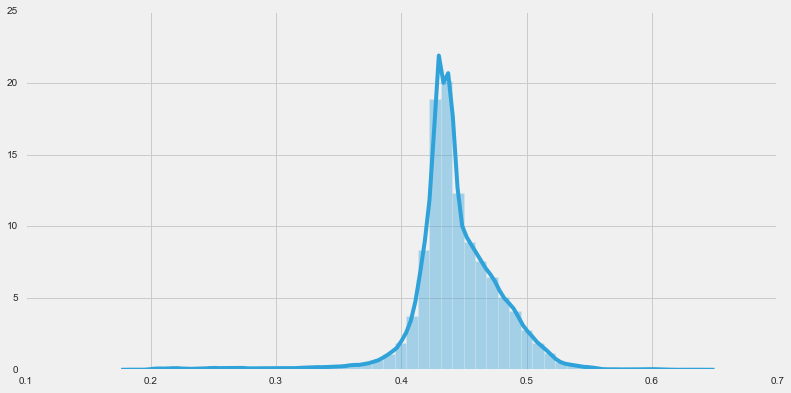

In [427]:
# # run model
y2 = model.predict(X2, verbose=1, batch_size=batch_size)

y_df = pd.Series(y2.flatten())
# y_df.hist(bins=50)
sns.distplot(y_df)
y_df.describe()

In [ ]:
# # now put into pic
imr = np.ones_like(data)*-999
imr=imr[0]
imr[ppcs[:,0],ppcs[:,1]]=y2.T[0]
imr=np.ma.masked_where(imr==-999,imr)
imr=imr.T

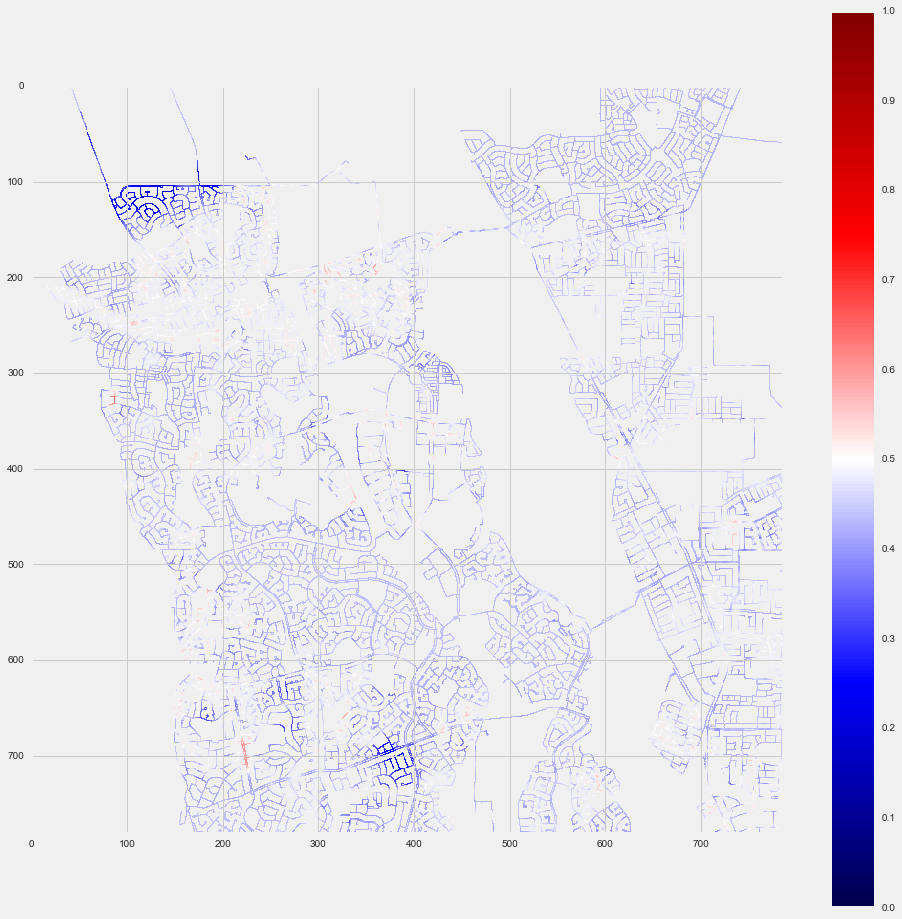

In [429]:
# just the ones with high confidence
plt.figure(figsize=(15,15))
plt.imshow(imr, interpolation='none', cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.show()

## Folium map of prediction
Make a folium map so we can zoom in on the predictions. We have high resolution base, predictions, and input image.

It might be a nicer map if I made it directly in leaflet but meh it's just for me

In [434]:
# work out image bounds in wgs84
image_bounds = np.array(box.exterior)

p0 = pyproj.Proj(init='epsg:%s'%crs_grid)
p1 = pyproj.Proj(init='epsg:%s'%4326)
image_bounds_wgs84 = np.array(pyproj.transform(p0,p1,image_bounds[:,0],image_bounds[:,1])).T
image_bounds_wgs84

bounds=np.array([image_bounds_wgs84.max(0),image_bounds_wgs84.min(0)]).tolist()
bounds=np.array([image_bounds_wgs84.min(0)[::-1],image_bounds_wgs84.max(0)[::-1]]).tolist()
bounds

[[-31.789512693283786, 115.71363117282907],
 [-31.70001859307964, 115.81954254482677]]

In [435]:
import folium
from folium import plugins
# high res tiles
dg_recent='http://api.tiles.mapbox.com/v4/digitalglobe.nal0g75k/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiZGlnaXRhbGdsb2JlIiwiYSI6ImNpcGg5dHkzYTAxM290bG1kemJraHU5bmoifQ.CHhq1DFgZPSQQC-DYWpzaQ'

In [436]:
import matplotlib.pyplot as plt

# from folium example, color array
def colorize(array, cmap='seismic', vmin=None, vmax=None):
    if vmin==None:
        vmin=array.min()
    if vmax==None:
        vmax=array.max()
    normed_data = (array - vmin) / (vmax - vmin)
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data)

colored_data = colorize(imr, cmap='seismic', vmin=0.0, vmax=1.0)
zm=imr.mean()
md=min(zm-imr.min(),imr.max()-zm)
colored_data_rel = colorize(imr, cmap='seismic', vmin=zm-md, vmax=zm+md)

In [440]:
map_osm = folium.Map(tiles=dg_recent, location=np.array(point)[::-1].tolist(), attr= "DigitalGlobe, Inc", control_scale=True, zoom_start=14, max_zoom=22, min_zoom=0.1)


# view results on top of rgb sat image
im2=data[1:4,:,:].copy()
im3 = np.transpose(im2,(1,2,0))[:,:,::-1]
im3+=0.5 # move it to 0-1
layer1=plugins.ImageOverlay(
    image=im3,
    bounds=bounds,
    opacity=0.9,
)
layer1.add_to(map_osm,name='input_image')

# show predictions
layer3=plugins.ImageOverlay(
    image=colored_data_rel,
#     image=colored_data_png, # this works too
    bounds=bounds,
    opacity=0.9,
)
layer3.add_to(map_osm,name='colored_results_rel')


# show predictions
layer2=plugins.ImageOverlay(
    image=colored_data,
#     image=colored_data_png, # this works too
    bounds=bounds,
    opacity=0.9,
)
layer2.add_to(map_osm,name='colored_results')


folium.LayerControl().add_to(map_osm)
map_file = outdir.joinpath('predictions_folium.html')
map_osm.save(map_file)
display(HTML('<a href="file://{link:}">file://{link:}</a>'.format(link=map_file.abspath())))

### Plot

This is hard to see, but later we will export to google maps and qgis

In [428]:
# # custom colormap just showing predictions above 0.5
# # http://jdherman.github.io/colormap/
# C= [[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,254,254],[255,250,250],[255,246,246],[255,242,242],[255,238,238],[255,234,234],[255,230,230],[255,226,226],[255,222,222],[255,218,218],[255,214,214],[255,210,210],[255,206,206],[255,202,202],[255,198,198],[255,194,194],[255,190,190],[255,186,186],[255,182,182],[255,178,178],[255,174,174],[255,170,170],[255,166,166],[255,161,161],[255,157,157],[255,153,153],[255,149,149],[255,145,145],[255,141,141],[255,137,137],[255,133,133],[255,129,129],[255,125,125],[255,121,121],[255,117,117],[255,113,113],[255,109,109],[255,105,105],[255,101,101],[255,97,97],[255,93,93],[255,89,89],[255,85,85],[255,81,81],[255,77,77],[255,73,73],[255,69,69],[255,65,65],[255,61,61],[255,57,57],[255,53,53],[255,49,49],[255,45,45],[255,41,41],[255,37,37],[255,33,33],[255,29,29],[255,25,25],[255,21,21],[255,17,17],[255,13,13],[255,9,9],[255,5,5],[255,1,1],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0],[255,0,0]]
# import matplotlib as mpl # in python
# cmap_wwr = mpl.colors.ListedColormap(np.array(C)/255.0)
# plt.imshow(Z, cmap=cm) # for example

In [441]:
# # view results on top of rgb sat image
# im2=data[1:4,:,:].copy()
# im3 = np.transpose(im2,(1,2,0))[:,:,::-1]
# im3+=0.5 # move it to 0-1
# plt.figure(figsize=(25,25))
# plt.imshow(im3, interpolation='none')

# plt.imshow(imr, interpolation='none', alpha=0.5, cmap='seismic', vmin=0, vmax=1)
# plt.colorbar()

# plt.savefig(outdir.joinpath('heatmap.png'))
# plt.show()

### save as geotiff for putting into QGIS

In [432]:
# # get image size and location
# path_tfw = path.glob('*tfw')[0]
# s=open(path_tfw).read()
# rx,a,b,ry,x0,y0 = [float(f) for f in s.split()]
# transform = (rx, a, x0, b, ry,  y0)
# transform

# # write geotiff
# import rasterio
# outfile = outdir.joinpath('heatmap.tiff')
# Z=imr.astype(np.float32)
# with rasterio.open(
#         outfile,
#         'w',
#         driver='GTiff',
#         height=Z.shape[0],
#         width=Z.shape[1],
#         count=1,
#         dtype=rasterio.float32,
#         crs={'init': 'EPSG:%s' % crs_grid},
#         transform=transform) as dest:
#     dest.write(Z, 1)
#     dest.write_mask(Z.mask)
#     dest.nodata=-999
# outfile

Path('../output/leak_detection_CNN__20170321-03-49-40/heatmap.tiff')

Note to view in qgis
- drag in
- double click
- style
- render type=single band pseudo color
- expand min max values
    - accuracy=actual (slower)
    - Min/Max
    - Load
- choose a color scheme that is zero centric
- apply